# Notebook Model Training and Tuning

## Objective

The objective of this project is to develop a predictive model that classifies the rank or rarity class of the monsters based on their level, health, energy and sanity attributes. The model aims to address the following business or data question:

**Business Question:** How can we automate the classification of monsters based on their attributes to provide users with insights into their ranks?

# Dataset Overview

The dataset used for the monster rarity classification problem was sourced from MongoDB and consisted of monsters that were randomly generated using the MonsterLab library. During the prepocessing phase, columns such as `_id`, `name`, and `damage`, where excluded from the dataset as they were not relevant for modeling purposes.

The dataset includes features like `level`, `health`, `energy`, `sanity`, and the target variable `rarity`. It contains 1,500 observations, with rarity classes ranging from `Rank 0` to `Rank 5`.

In [1]:
# pip install pymongo in Colab
! python -m pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 31.5 MB/s eta 0:00:00


In [2]:
# pip install categorical encoders
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.7 MB/s eta 0:00:00


In [3]:
# Imports
import pymongo
from pymongo import MongoClient
from getpass import getpass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from xgboost import XGBClassifier

## I. Data Wrangling

Custom wrangling function to establish a connection to MongoDB, retrieve the monster data, convert it into a pandas DataFrame, and perform necessary data cleaning steps. This function excludes irrelevant features and ensures the dataset is ready for further analysis.

In [4]:
def wrangle():
  """
  Retrieves data from a MongoDB collection, performs data wrangling, and returns a cleaned DataFrame.

  This function prompts the user to enter the MongoDB URI and creates a connection to the MongoDB client.
  It accesses a specified database and collection. The function retrieves the data from the collection and
  converts it into a DataFrame. It then undergoes several data cleaning steps, including removing the `_id`
  column, converting the `Timestamp` column to a datetime object, and removing high cardinality categorical
  columns based on a specific cutoff value. The resulting DataFrame is returned as the output.

  Returns:
      df (DataFrame): The cleaned DataFrame obtained from the MongoDB collection.
  """

  # Prompt the user to enter the MongoDB URI
  secret_uri = getpass('Enter MongoDB_URI: ')

  # Connect to the MongoDB client
  client = MongoClient(secret_uri)

  # Access the database and collection
  db = client.Database
  monsters = db.monsters

  # Retrieve the data from the collection
  data = list(monsters.find())

  # Convert the data to a DataFrame
  df = pd.DataFrame(data)

  # Remove the `_id` column
  df.drop(columns=['_id'], inplace=True)

  # Convert `Timestamp` into a datetime object
  df.Timestamp = pd.to_datetime(df['Timestamp'])

  # Exclude high cardinality categorical columns
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
                if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

In [5]:
# Assign the DataFrame to the to the variable `df`
# to get access to MongoDB database and work with the cleaned data
df = wrangle()

Enter MongoDB_URI: ··········


In [6]:
# Print a random sample of the dataset
df.sample(10)

,Type,Level,Rarity,Health,Energy,Sanity,Timestamp
969,Demonic,8,Rank 0,15.28,15.43,15.73,2023-06-15 12:25:26
1465,Dragon,7,Rank 2,40.63,41.17,42.00,2023-06-15 12:25:26
980,Devilkin,9,Rank 0,18.34,17.95,17.80,2023-06-15 12:25:26
322,Dragon,13,Rank 0,25.75,26.63,26.66,2023-06-15 12:25:26
428,Elemental,11,Rank 2,67.56,64.02,66.83,2023-06-15 12:25:26
103,Demonic,11,Rank 4,114.57,112.54,112.82,2023-06-15 12:25:26
1100,Fey,8,Rank 0,16.61,16.93,16.37,2023-06-15 12:25:26
32,Devilkin,10,Rank 1,39.69,40.12,41.52,2023-06-15 12:25:26
339,Elemental,10,Rank 1,40.40,39.86,40.60,2023-06-15 12:25:26
1219,Undead,3,Rank 1,11.15,12.40,10.54,2023-06-15 12:25:26


In [7]:
# Features with NaN values
df.isnull().sum().sum()

0

In [8]:
# Verify column names and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Type       1500 non-null   object        
 1   Level      1500 non-null   int64         
 2   Rarity     1500 non-null   object        
 3   Health     1500 non-null   float64       
 4   Energy     1500 non-null   float64       
 5   Sanity     1500 non-null   float64       
 6   Timestamp  1500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 82.2+ KB


In [9]:
# Summary statistics
df.describe()

,Level,Health,Energy,Sanity
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,7.876667,38.908920,38.823760,38.825820
std,4.456010,32.318894,32.312967,32.368774
min,1.000000,1.000000,1.010000,1.280000
25%,4.000000,15.350000,15.300000,15.320000
50%,7.000000,28.265000,28.330000,28.475000
75%,11.000000,54.112500,53.402500,53.945000
max,20.000000,213.090000,215.440000,217.660000


## Constant Value Column

The `Timestamp` column in the monsters DataFrame has a constant value for all rows, so it does not provide any meaningful information for analysis or visualization. However, when the app is deployed, information about the timestamp will be showed in the `/model` tab. For this reason, the `Timestamp` column is kept in the DataFrame.

In [10]:
# Retrieve all the unique values from the `Timestamp` column
df.Timestamp.unique()

array(['2023-06-15T12:25:26.000000000'], dtype='datetime64[ns]')

In [11]:
df.Timestamp.nunique()

1

# II. Data Splitting

The dataset is divided into training and testing sets to facilitate model training and evaluation.

In [12]:
# Split the data into feature matrix and target vector
target = 'Rarity'

y = df[target] # target vector
X = df.drop(columns=target) # feature matrix

In [13]:
# Randomly split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Baseline Calculation

Identify the most frequent class in the `Rarity` column of the training set and calculate the baseline accuracy score to serve as a reference point for model performance.

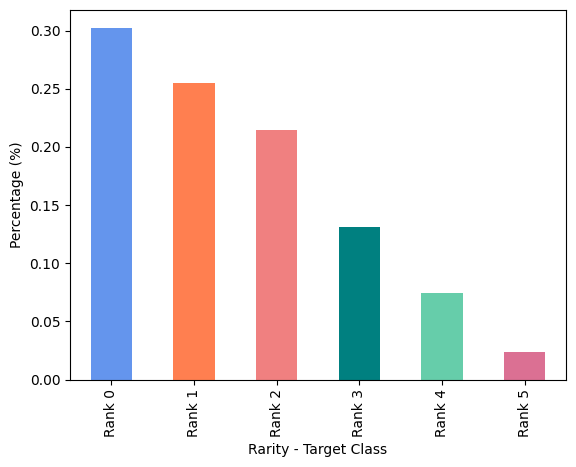

In [14]:
# Check the distribution of the target column `Rarity`
y_train.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral', 'lightcoral', 'teal', 'mediumaquamarine', 'palevioletred'])
plt.xlabel('Rarity - Target Class')
plt.ylabel('Percentage (%)');

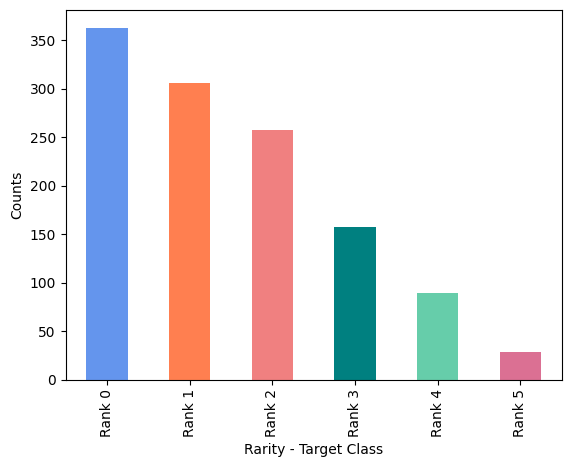

In [15]:
y_train.value_counts().plot(kind='bar', color=['cornflowerblue', 'coral', 'lightcoral', 'teal', 'mediumaquamarine', 'palevioletred'])
plt.xlabel('Rarity - Target Class')
plt.ylabel('Counts');

In [16]:
baseline = y_train.value_counts(normalize=True).idxmax()
print('Baseline Majority Class:', baseline)

Baseline Majority Class: Rank 0


In [17]:
# Calculate the baseline accuracy score
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.3025


## IV. Model Building and Metrics Evaluation

Choose three models for training and tuning:
  - Random Forest (RF)
  - Extreme Gradient Boosting (XGBoost)
  - Support Vector Machines (SVM)

Note: These models can handle both numerical and categorical features in the dataset.

Evaluate models using metrics such as accuracy and ROC AUC OVO.

Examine both imbalanced and balanced class scenarios to assess the models' performance.

### Model 1A - Imbalanced Random Forest (RF)

In [18]:
# Model 1a - Imbalanced RF

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['Level', 'Health', 'Energy', 'Sanity']),
    ('categorical', OneHotEncoder(), ['Type']),
])

# Create the pipeline
imb_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
imb_rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(imb_rf_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', scores)
print('ROC AUC OvO Imbalanced RF:', np.mean(scores))

Cross-Validation Scores: [0.95978173 0.954271   0.92200945 0.97839372 0.97926687]
ROC AUC OvO Imbalanced RF: 0.9587445566198092


In [19]:
# Perform cross-validation and obtain predicted labels
imb_rf_y_pred = cross_val_predict(imb_rf_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Imbalanced RF Classification Report: ')
print(classification_report(y_train, imb_rf_y_pred))

Imbalanced RF Classification Report: 
              precision    recall  f1-score   support

      Rank 0       0.99      1.00      0.99       363
      Rank 1       0.96      0.98      0.97       306
      Rank 2       0.89      0.95      0.92       257
      Rank 3       0.87      0.85      0.86       157
      Rank 4       0.77      0.75      0.76        89
      Rank 5       1.00      0.25      0.40        28

    accuracy                           0.93      1200
   macro avg       0.91      0.80      0.82      1200
weighted avg       0.93      0.93      0.92      1200



###  Model 2A - Imbalanced Extreme Gradient Boosting (XGBoost)

In [20]:
# Model 2a - Imbalanced XGBoost

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Perform label encoding on the target variable on train set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create the pipeline
imb_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42))
])

# Fit the model
imb_xgb_model.fit(X_train, y_train_encoded)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(imb_xgb_model, X_train, y_train_encoded, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', scores)
print('ROC AUC OvO Imbalanced XGB:', scores.mean())


Cross-Validation Scores: [0.97000018 0.93690656 0.89317391 0.97441707 0.98008927]
ROC AUC OvO Imbalanced XGB: 0.9509173960536714


In [21]:
# Perform cross-validation and obtain predicted labels
imb_xgb_y_pred = cross_val_predict(imb_xgb_model, X_train, y_train_encoded, cv=cv)
# Imbalanced Random Forest Classification Report
print('Imbalanced XGBoost Classification Report: ')
print(classification_report(y_train_encoded, imb_xgb_y_pred))

Imbalanced XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       363
           1       0.96      0.99      0.98       306
           2       0.94      0.95      0.95       257
           3       0.88      0.90      0.89       157
           4       0.74      0.78      0.76        89
           5       0.82      0.32      0.46        28

    accuracy                           0.94      1200
   macro avg       0.89      0.82      0.84      1200
weighted avg       0.94      0.94      0.94      1200



### Model 3A - Imbalanced Support Vector Machines (SVM)

In [22]:
# Model 3a - Imbalanced SVM

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['Level', 'Health', 'Energy', 'Sanity']),
    ('categorical', OneHotEncoder(), ['Type']),
])

# Create the pipeline
imb_svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42,
                       probability=True,
                       decision_function_shape='ovo'))
])

# Fit the model
imb_svm_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
imb_svm_scores = cross_val_score(imb_svm_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', imb_svm_scores)
print('ROC AUC OvO Imbalanced SVM:', imb_svm_scores.mean())

Cross-Validation Scores: [0.97798678 0.97480065 0.96601558 0.99027981 0.9909615 ]
ROC AUC OvO Imbalanced SVM: 0.9800088622224434


In [23]:
# Imbalanced SVM Classification Report
# Perform cross-validation and obtain predicted labels
imb_svm_y_pred = cross_val_predict(imb_svm_model, X_train, y_train, cv=cv)
print('Imbalanced SVM Classification Report: ')
print(classification_report(y_train, imb_svm_y_pred, zero_division=0))

Imbalanced SVM Classification Report: 
              precision    recall  f1-score   support

      Rank 0       0.96      1.00      0.98       363
      Rank 1       0.89      0.96      0.92       306
      Rank 2       0.85      0.86      0.85       257
      Rank 3       0.81      0.80      0.80       157
      Rank 4       0.72      0.61      0.66        89
      Rank 5       0.00      0.00      0.00        28

    accuracy                           0.88      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.86      0.88      0.87      1200



### Model 1B -  Balanced Random Forest (RF)

In [24]:
# Model 1b - Balanced RF

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
bal_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampling', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
bal_rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_rf_scores = cross_val_score(bal_rf_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', bal_rf_scores)
print('ROC AUC OvO Balanced RF:', bal_rf_scores.mean())


Cross-Validation Scores: [0.97482052 0.96157321 0.9083498  0.98483507 0.9715284 ]
ROC AUC OvO Balanced RF: 0.9602214013749324


In [25]:
# Perform cross-validation and obtain predicted labels
bal_rf_y_pred = cross_val_predict(bal_rf_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Balanced RF Classification Report: ')
print(classification_report(y_train, bal_rf_y_pred))

Balanced RF Classification Report: 
              precision    recall  f1-score   support

      Rank 0       0.98      0.99      0.99       363
      Rank 1       0.97      0.98      0.97       306
      Rank 2       0.95      0.95      0.95       257
      Rank 3       0.82      0.87      0.84       157
      Rank 4       0.69      0.66      0.68        89
      Rank 5       0.68      0.46      0.55        28

    accuracy                           0.93      1200
   macro avg       0.85      0.82      0.83      1200
weighted avg       0.92      0.93      0.92      1200



### Model 2B - Balanced Extreme Gradient Boosting (XGBoost)

In [26]:
# Model 2b - Balanced XGBoost

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
bal_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_encoded)), random_state=42))
])

# Fit the model
bal_xgb_model.fit(X_train, y_train_encoded)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_xgb_scores = cross_val_score(bal_xgb_model, X_train, y_train_encoded, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', bal_xgb_scores)
print('ROC AUC OvO Balanced XGB:', bal_xgb_scores.mean())


Cross-Validation Scores: [0.98504535 0.96406289 0.88383206 0.98736172 0.98696265]
ROC AUC OvO Balanced XGB: 0.961452933038248


In [27]:
# Perform cross-validation and obtain predicted labels
bal_xgb_y_pred = cross_val_predict(bal_xgb_model, X_train, y_train_encoded, cv=cv)
# Imbalanced Random Forest Classification Report
print('Balanced XGBoost Classification Report: ')
print(classification_report(y_train_encoded, bal_xgb_y_pred))

Balanced XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       363
           1       0.98      0.98      0.98       306
           2       0.96      0.95      0.96       257
           3       0.92      0.91      0.91       157
           4       0.78      0.85      0.82        89
           5       0.72      0.46      0.57        28

    accuracy                           0.95      1200
   macro avg       0.89      0.86      0.87      1200
weighted avg       0.95      0.95      0.95      1200



### Model 3B - Balanced Support Vector Machines (SVM)

In [28]:
# Model 3b - SVM Balanced

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
bal_svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampling', RandomUnderSampler(random_state=42)),
    ('classifier', SVC(random_state=42,
                       probability=True,
                       decision_function_shape='ovo'))
])

# Fit the model
bal_svm_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_svm_scores = cross_val_score(bal_svm_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', bal_svm_scores)
print('ROC AUC OvO Balanced SVM:', bal_svm_scores.mean())


Cross-Validation Scores: [0.98928975 0.99318055 0.91904762 0.97989563 0.98606696]
ROC AUC OvO Balanced SVM: 0.9734961009815477


In [29]:
# Balanced SVM Classification Report
# Perform cross-validation and obtain predicted labels
bal_svm_y_pred = cross_val_predict(bal_svm_model, X_train, y_train, cv=cv)
print('Balanced SVM Classification Report: ')
print(classification_report(y_train, bal_svm_y_pred, zero_division=0))

Balanced SVM Classification Report: 
              precision    recall  f1-score   support

      Rank 0       0.97      1.00      0.98       363
      Rank 1       0.90      0.97      0.93       306
      Rank 2       0.92      0.87      0.90       257
      Rank 3       0.94      0.85      0.89       157
      Rank 4       0.83      0.76      0.80        89
      Rank 5       0.71      0.71      0.71        28

    accuracy                           0.92      1200
   macro avg       0.88      0.86      0.87      1200
weighted avg       0.92      0.92      0.92      1200



## V. Hyperparameter Tuning

Perform hyperparameter tuning on balanced models using randomized search technique. Explore various hyperparameter combinations and select the set of hyperparameters that maximizes the `roc_auc_ovo` score.

### Tuning The Random Forest (RF) Model

In [30]:
%%time
# Balanced Random Forest Tuning

# Define the parameter distribution
param_grid = {
    # Number of trees in random forest
    'classifier__n_estimators': range(100, 1000, 10),
    # Number of features to consider at every split
    'classifier__max_features': ['log2', 'sqrt', None],
    # Maximum number of levels in tree
    'classifier__max_depth': [None, 5, 10, 20, 50],
    # Minimum number of samples required to split a node
    'classifier__min_samples_split': [3, 4, 5, 7, 8],
    # Method of selecting sample for training each tree
    'classifier__bootstrap': [True, False]
}

# Create the randomized search object
random_search_rf = RandomizedSearchCV(estimator=bal_rf_model, scoring='roc_auc_ovo', param_distributions=param_grid, n_iter=10, cv=15, random_state=42, n_jobs =-1)

# Fit the randomized search to the training data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print('Best Hyperparameters:', random_search_rf.best_params_)
print('Best Score:', random_search_rf.best_score_)


Best Hyperparameters: {'classifier__n_estimators': 710, 'classifier__min_samples_split': 5, 'classifier__max_features': None, 'classifier__max_depth': 20, 'classifier__bootstrap': True}
Best Score: 0.9891851333125843
CPU times: user 7.68 s, sys: 319 ms, total: 7.99 s
Wall time: 7min 3s


In [31]:
%%time
# Build a RF Model with the tuned hyperparameters

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
tuned_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)),
    ('undersampling', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=710,
                                          min_samples_split=5,
                                          max_features=None,
                                          max_depth=20,
                                          bootstrap=True,
                                          random_state=42))
])

# Fit the model
tuned_rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_rf_scores = cross_val_score(tuned_rf_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', tuned_rf_scores)
print('ROC AUC OvO Tuned RF:', tuned_rf_scores.mean())


Cross-Validation Scores: [0.99398556 0.9727556  0.9306857  0.98685856 0.98762387]
ROC AUC OvO Tuned RF: 0.9743818580335268
CPU times: user 28.8 s, sys: 146 ms, total: 28.9 s
Wall time: 31.8 s


In [32]:
# Measure the improvement of the Random Forest (RF) model after tuning the hyperparameters
print('Improvement of {:0.2f}%.'.format( 100 * (tuned_rf_scores.mean() - bal_rf_scores.mean()) /bal_rf_scores.mean()))

Improvement of 1.47%.


In [35]:
# Perform cross-validation and obtain predicted labels
tuned_rf_y_pred = cross_val_predict(tuned_rf_model, X_train, y_train, cv=cv)
print('Tuned RF Classification Report: ')
print(classification_report(y_train, tuned_rf_y_pred))

Tuned RF Classification Report: 
              precision    recall  f1-score   support

      Rank 0       1.00      1.00      1.00       363
      Rank 1       0.98      0.99      0.99       306
      Rank 2       0.97      0.97      0.97       257
      Rank 3       0.94      0.92      0.93       157
      Rank 4       0.78      0.81      0.80        89
      Rank 5       0.56      0.50      0.53        28

    accuracy                           0.95      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.95      0.95      0.95      1200



### Tuning The Extreme Gradient Boosting (XGBoost) Model

In [36]:
%%time
# Balanced XGBoost Tuning

# Define the parameter distribution
param_grid_xgb = {
    # Control how much the model learns from each mistake it makes
    'classifier__learning_rate': np.arange(0.01, 0.1, 0.01),
    # Number of decision trees to be built
    'classifier__n_estimators': range(100, 1000, 100),
    # Maximum depth of each decision tree
    'classifier__max_depth': [3, 5, 8, 10, 15],
    # Minimum number of instances required in each child node
    'classifier__min_child_weight': range(1, 11),
    # Pruning of decision tree branches if the improvement is not significant enough
    'classifier__gamma': np.arange(0, 1.1, 0.1),
    # Fraction of samples used to train each tree
    'classifier__subsample': np.arange(0.1, 1.1, 0.1),
    # Fraction of features used to train each tree
    'classifier__colsample_bytree': np.arange(0.5, 1.0, 0.1),
}

# Create the randomized search object
rsearch_xgb = RandomizedSearchCV(estimator=bal_xgb_model, scoring='roc_auc_ovo', param_distributions=param_grid_xgb, n_iter=10, cv=15, random_state=42, n_jobs=-1)

# Fit the randomized search to the training data
rsearch_xgb.fit(X_train, y_train_encoded)

# Print the best parameters and best score
print('Best Parameters:', rsearch_xgb.best_params_)
print('Best Score:', rsearch_xgb.best_score_)


Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 700, 'classifier__min_child_weight': 1, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.08, 'classifier__gamma': 0.6000000000000001, 'classifier__colsample_bytree': 0.5}
Best Score: 0.9803562840983755
CPU times: user 21.7 s, sys: 677 ms, total: 22.3 s
Wall time: 8min 27s


In [37]:
%%time
# Build XGBoost Model with the tuned hyperparameters

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
tuned_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(objective='multi:softmax',
                                 num_class=len(np.unique(y_train_encoded)),
                                 random_state=42,
                                 subsample=0.8,
                                 n_estimators=700,
                                 min_child_weight=1,
                                 max_depth=15,
                                 learning_rate=0.08,
                                 gamma=0.6000000000000001,
                                 colsample_bytree=0.5))
])

# Fit the model
tuned_xgb_model.fit(X_train, y_train_encoded)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_xgb_scores = cross_val_score(tuned_xgb_model, X_train, y_train_encoded, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', tuned_xgb_scores)
print('ROC AUC OvO Tuned XGB:', tuned_xgb_scores.mean())

Cross-Validation Scores: [0.9873091  0.96147752 0.9164436  0.99110374 0.98896557]
ROC AUC OvO Tuned XGB: 0.9690599064819768
CPU times: user 2min, sys: 1.93 s, total: 2min 2s
Wall time: 1min 24s


In [38]:
# Measure the improvement of the XGBoost model after tuning the hyperparameters
print('Improvement of {:0.2f}%.'.format( 100 * (tuned_xgb_scores.mean() - bal_xgb_scores.mean()) /bal_xgb_scores.mean()))

Improvement of 0.79%.


In [40]:
# Tuned XGBoost Classification Report

# Perform cross-validation and obtain predicted labels
tuned_xgb_y_pred = cross_val_predict(tuned_xgb_model, X_train, y_train_encoded, cv=cv)
print('Tuned XGB Classification Report: ')
print(classification_report(y_train_encoded, tuned_xgb_y_pred))

Tuned XGB Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       363
           1       0.97      0.98      0.97       306
           2       0.95      0.96      0.95       257
           3       0.92      0.90      0.91       157
           4       0.79      0.83      0.81        89
           5       0.74      0.50      0.60        28

    accuracy                           0.95      1200
   macro avg       0.89      0.86      0.87      1200
weighted avg       0.95      0.95      0.95      1200



### Tuning The Support Vector Machines (SVM) Model

In [41]:
%%time
# Balanced SVM Tuning

# Define the parameter distribution
param_grid_svm = {
    # Penalty for misclassified points in the model
    'classifier__C': range(1, 10, 1),
    # Shape of the decision boundary
    'classifier__kernel': ['rbf', 'poly'], # `rbf` creates a smooth boundary, `poly` creates a more complex one
    # Control how much weight each training example has in the model
    'classifier__gamma': ['scale', 0.1, 1, 10] # `scale` is automatically calculated
}

# Create the randomized search object
rsearch_svm = RandomizedSearchCV(estimator=bal_svm_model, scoring='roc_auc_ovo', param_distributions=param_grid_svm, n_iter=10, cv=15, random_state=42, n_jobs=-1)

# Fit the randomized search to the training data
rsearch_svm.fit(X_train, y_train)

# Print the best parameters and best score
print('Best Hyperparameters:', rsearch_svm.best_params_)
print('Best Score:', rsearch_svm.best_score_)


Best Hyperparameters: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 7}
Best Score: 0.9982415188297542
CPU times: user 1.64 s, sys: 120 ms, total: 1.76 s
Wall time: 2min 4s


In [42]:
# Build a SVM model with the tuned hyperparameters

# Specify the column names for numeric and categorical columns
numeric_cols = ['Level', 'Health', 'Energy', 'Sanity']
categorical_cols = ['Type']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Exclude remaining columns from the pipeline
)

# Create the pipeline with preprocessing, oversampling, undersampling, and model
tuned_svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampling', RandomUnderSampler(random_state=42)),
    ('classifier', SVC(random_state=42,
                       probability=True,
                       decision_function_shape='ovo',
                       C=7,
                       kernel='rbf',
                       gamma=0.1))
])

# Fit the model
tuned_svm_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_svm_scores = cross_val_score(tuned_svm_model, X_train, y_train, cv=cv, scoring='roc_auc_ovo')
print('Cross-Validation Scores:', tuned_svm_scores)
print('ROC AUC OvO Tuned SVM:', tuned_svm_scores.mean())

Cross-Validation Scores: [0.99768449 0.99833475 0.97280376 0.99924099 0.99829715]
ROC AUC OvO Tuned SVM: 0.993272225898018


In [51]:
# Balanced SVM Classification Report
# Perform cross-validation and obtain predicted labels
tuned_svm_y_pred = cross_val_predict(tuned_svm_model, X_train, y_train, cv=cv)
print('Tuned SVM Classification Report: ')
print(classification_report(y_train, tuned_svm_y_pred, zero_division=0))

Tuned SVM Classification Report: 
              precision    recall  f1-score   support

      Rank 0       0.98      1.00      0.99       363
      Rank 1       0.97      0.98      0.98       306
      Rank 2       0.96      0.97      0.96       257
      Rank 3       0.99      0.89      0.94       157
      Rank 4       0.88      0.94      0.91        89
      Rank 5       0.92      0.86      0.89        28

    accuracy                           0.97      1200
   macro avg       0.95      0.94      0.94      1200
weighted avg       0.97      0.97      0.97      1200



In [44]:
# Measure the improvement of the SVM model after tuning the hyperparameters
print('Improvement of {:0.2f}%.'.format( 100 * (tuned_svm_scores.mean() - bal_svm_scores.mean()) /bal_svm_scores.mean()))

Improvement of 2.03%.


In terms of overall performance, the Tuned SVM model stands out with the highest ROC AUC OvO score and accuracy. It demonstrates superior precision, recall, and F1-score values compared to the other two models.

## VI. Final Evaluation

Use the best performer model based on the evaluation metrics to further assess its performance by using the test set to verify its effectiveness and reliability in real-world scenarios.

In [45]:
# Evaluate the SVM model's overall performance on the test set
test_score = tuned_svm_model.score(X_test, y_test)
print('Test Accuracy:', test_score)


Test Accuracy: 0.96


In [48]:
# Evaluate the SVM model's roc_auc_ovo score on the test set
roc_auc_ovo_score_tuned_svm = roc_auc_score(y_test, tuned_svm_model.predict_proba(X_test), multi_class='ovo')
print('ROC AUC OVO Test score', roc_auc_ovo_score_tuned_svm)

ROC AUC OVO Test score 0.9845260295260296


In [49]:
# Test Classification Report
y_test_pred = tuned_svm_model.predict(X_test)

print('Test Classification Report SVM: ')
print(classification_report(y_test, y_test_pred));

Test Classification Report SVM: 
              precision    recall  f1-score   support

      Rank 0       0.99      1.00      0.99        93
      Rank 1       0.96      0.99      0.97        72
      Rank 2       0.95      0.97      0.96        60
      Rank 3       0.92      0.87      0.89        39
      Rank 4       0.94      0.91      0.92        33
      Rank 5       1.00      0.67      0.80         3

    accuracy                           0.96       300
   macro avg       0.96      0.90      0.92       300
weighted avg       0.96      0.96      0.96       300



## VII. Feature Importance

Plot feature importances for the selected model to gain insights into the significance of different attributes in predicting monster rarity.



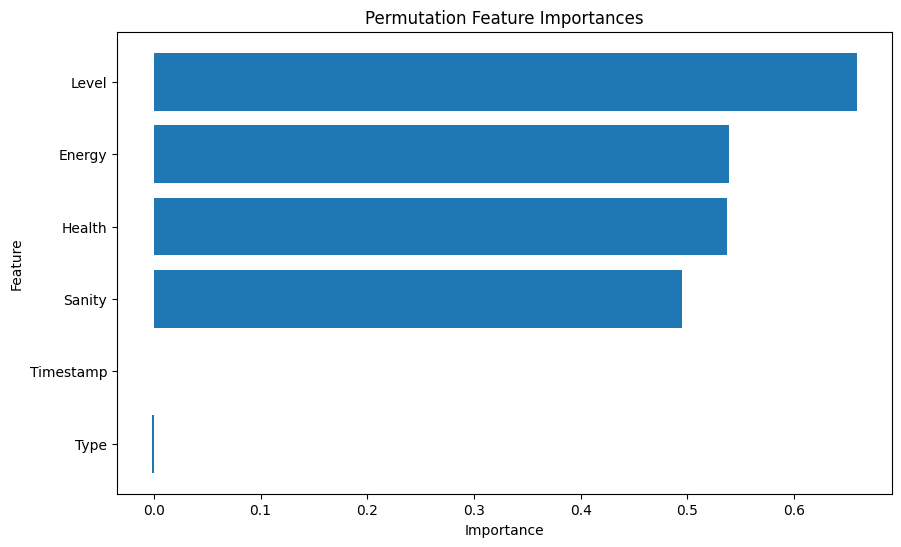

In [50]:
# Calculate permutation importances
result = permutation_importance(tuned_svm_model, X_test, y_test, n_repeats=10, random_state=42)

# Get the feature importances
importances = result.importances_mean
feature_names = X_test.columns

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances.sort_values('Importance', ascending=True, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importances')
plt.show()


## Methodology

The methodology employed in this project followed a systematic approach to solve the problem of classifying monster rarity based on attributes such as level, health, energy and sanity. The overall approach consisted of several key steps, including data collection, data preprocessing, exploratory data analysis (EDA), model selection, hyperparameter tuning and evaluation.

- The dataset for this project was obtained from a MongoDB database using the custom `wrangle()` function to establish a connection, retrieve the desired collection, and convert it into a pandas DataFrame.

- The preprocessing steps within the `wrangle()` function included data cleaning steps such as dropping the `_id` column, converting the `Timestamp` column into a datetime object, and excluding high cardinality categorical columns (those with more than a specified number of unique values, in this case, 100).

- During the EDA phase, summary statistics were generated to gain an understanding of the distribution and range of numerical attributes. It was observed that no missing values were present in the dataset, ensuring the completeness of the data. However, further analysis revealed that the `Timestamp` column had a constant value for all rows and did not provide any meaningful information for analysis or visualization. In spite of that, the `Timestamp` column was kept in the DataFrame to display information about the timestamp when the app is deployed. This decision ensures that the deployed model can provide insights related to the timestamp when users interact with the `/model` tab on the web application.

- Aditionally, the distribution of the target feature was examined revealing an imbalance in the `Rarity` classes. This means that some rarity classes were overrepresented compared to others.

- The majority class (`Rank 0`), was selected as the baseline prediction for all instances. The baseline accuracy was 30%.

- Following, three different algorithms (Random Forest, XGBoost, and Support Vector Machines) were chosen for modeling based on their suitability for classification tasks and their ability to handle both numerical and categorical features present in the dataset.

## Challenges and Techniques

- The classes for the target variable were imbalanced. To address this challenge, the models were initially trained and evaluated using the imbalanced dataset to assess their performance in real-world scenarios. All these models struggled to classify the minority classes, especially `Rank 4` and `Rank 5`.

- Next, we employed techniques such as SMOTE (Synthetic Minority Over-sampling Technique) oversampling and random undersampling to balance the classes and improve the models' ability to predict the minority classes. Higher accuracy and better performance when identifying rare classes were observed, compared to the performance of the imbalanced data.

- Cross-validation was performed using the `roc_auc_ovo` scoring metric to ensure unbiased evaluation and account for the imbalanced nature of the target feature. This metric is suitable for multi-class classification tasks and provides insights into the models' ability to differentiate between various rarity classes.

## Hyperparameter Tuning and Model Evaluation Metrics

- Fine-tuning was carried out for each model to maximize the `roc_auc_ovo` score using a randomized search technique to find the optimal set of hyperparameters for each model.

- Afterwards, classification reports were analyzed to get a complete picture of the models' ability to predict minority classes. The evaluation was performed using metrics such as accuracy, precision, recall, f1-score, macro-average F1-score, and weighted-average F1-score. The models were fine-tuned to achieve a balance between overall accuracy and satisfactory performance for the minority classes.

- The Support Vector Machines (SVM) model proved to be the best performer based on the evaluation metrics. To ensure its real-world performance, it underwent further evaluation using the test set.

- The feature importance of the selected SVM model was plotted to determine the significance of different attributes in predicting monster rarity. This analysis revealed that the level attribute had the highest importance in predicting monster rarity, followed by energy, health, and sanity attributes.

## Results

Based on the project results, the predictive model that was developed showed impressive performance and effectiveness. To provide a clear understanding, the key findings and metrics were analyzed for each tuned model, and they are as follows:


|     Metrics       |  Tuned RF    |  Tuned XGB   |  Tuned SVM   |
|-------------------|--------------|--------------|--------------|
| ROC AUC OvO       |   0.974      |   0.969      |   0.993      |
| Accuracy          |   0.95       |   0.95       |   0.97       |
| Macro Avg F1      |   0.87       |   0.87       |   0.94       |
| Weighted Avg F1   |   0.95       |   0.95       |   0.97       |
| Precision (Rank 0)|   1.00       |   0.99       |   0.98       |
| Precision (Rank 1)|   0.98       |   0.97       |   0.97       |
| Precision (Rank 2)|   0.97       |   0.95       |   0.96       |
| Precision (Rank 3)|   0.94       |   0.92       |   0.99       |
| Precision (Rank 4)|   0.78       |   0.79       |   0.88       |
| Precision (Rank 5)|   0.56       |   0.74       |   0.92       |
| Recall (Rank 0)   |   1.00       |   0.99       |    1.00      |
| Recall (Rank 1)   |   0.99       |   0.98       |   0.98       |
| Recall (Rank 2)   |   0.97       |   0.96       |   0.97       |
| Recall (Rank 3)   |   0.92       |   0.90       |   0.89       |
| Recall (Rank 4)   |   0.81       |   0.83       |   0.94       |
| Recall (Rank 5)   |   0.50       |   0.50       |   0.86       |
| F1-score (Rank 0) |   1.00       |   0.99       |   0.99       |
| F1-score (Rank 1) |   0.99       |   0.97       |   0.98       |
| F1-score (Rank 2) |   0.97       |   0.95       |   0.96       |
| F1-score (Rank 3) |   0.93       |   0.91       |   0.94       |
| F1-score (Rank 4) |   0.80       |   0.81       |   0.91       |
| F1-score (Rank 5) |   0.53       |   0.60       |   0.89       |


### Metrics Analysis - Best Performing Model:


The SVM model demonstrated the highest accuracy of 97% among the tuned models. It also achieved the highest precision, recall, and F1-score across most classes, indicating a well-balanced performance in terms of both precision and recall.

The SVM model had the highest ROC AUC score of 0.993, indicating excellent performance in distinguishing between the ranks of the monsters across all ranks.



## Model Deployment

The trained model will be deployed to create a user-friendly application where users can input the level, health, energy, and sanity attributes of a monster and receive a predicted rarity class for the monster along with a confidence percentage. The application will also handle missing attribute values by generating random statistics to ensure predictions can still be made.

## Conclusion

To sum up, the project has effectively achieved its objective of creating a predictive model that classifies monster rarity based on their attributes. Various machine learning algorithms and techniques were utilized to overcome the problem of imbalanced data. After extensive evaluation and hyperparameter tuning, the Random Forest model showed the best overall performance, providing precise predictions and efficiently handling imbalanced classes.

Integrating the model into a practical application will provide users with a user-friendly, automated tool that can assist in classifying monster rarity and aiding in decision-making.
